# CHB MIT DATABASE

1. Load edf data
2. define class sz/nsz
3. insert class cols
4. concat
5. windowing
6. ensemple learn resnet152, inceptionv3, incep+resnet
7. define OHEM loss
8. build network
9. evaluate
10. calculate for confussion matrices (f1-score etc.)

In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.1
Scikit-Learn 0.24.2
GPU is available


## GLOBAL VARIABLES

In [2]:
cwd = os.getcwd()
FREQ = 256
database_path = 'Dataset/CHB-MIT/chb-mit-scalp-eeg-database-1.0.0/'
filtered_database_path = 'Dataset/CHB-MIT/Filtered-chb-mit/'
filted_db_parquet_path = "Dataset/CHB-MIT/dataframe-parquet"
edf_file_type = ".edf"
patient_one_path = 'chb04/'
summary_txt_file_type = "-summary.txt"
cwd

'/Users/niklashjort/Desktop/Notes/Speciale/projects'

In [3]:
def get_all_patient_folder_names(database_path):
    folders = os.listdir(database_path)
    patient_folder_names = [(database_path + "/" + x) for x in folders if (x.find(".DS_Store") == -1)]
    return patient_folder_names

def get_all_file_names(directory):
    files = os.listdir(directory)
    edfFileNameList = [(directory + "/" + x) for x in files if (x.endswith(edf_file_type))]
    summary_info_file_name = [(directory + "/" + x) for x in files if (x.endswith(summary_txt_file_type))]
    return (summary_info_file_name[0], edfFileNameList)

In [4]:
# Testing:
summary_file_path, edf_file_paths = get_all_file_names(get_all_patient_folder_names(filtered_database_path)[0])

print(f"summary file name: {summary_file_path} edf file name: {edf_file_paths[0]}")

summary file name: Dataset/CHB-MIT/Filtered-chb-mit//chb20/chb20-summary.txt edf file name: Dataset/CHB-MIT/Filtered-chb-mit//chb20/chb20_59.edf


In [5]:
def ReadEdfFile(FileName, print_reader_info = False):
    try:
        if(print_reader_info):
            data = mne.io.read_raw_edf(FileName)
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            return converted_raw
        else:
            data = mne.io.read_raw_edf(FileName, verbose='error')
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            return converted_raw
    except Exception as e:
        pass

## PROBLEM! bad channel: solution find conda mne and modify package.

In [6]:
print(mne.__version__)
bla = "Dataset/CHB-MIT/Filtered-chb-mit//chb18/chb18_01.edf"
ReadEdfFile(bla)

0.16.2


In [7]:
# Testing 
test_df = ReadEdfFile(edf_file_paths[8], print_reader_info=False)
test_df.head()

,FP1-F7,F7-T7,T7-P7,P7-O1,.-0,FP1-F3,F3-C3,C3-P3,P3-O1,.-1,...,FP2-F8,F8-T8,T8-P8,P8-O2,.-4,P7-T7,T7-FT9,FT9-FT10,FT10-T8,STI 014
0,5.919414e-05,6.388278e-05,-3.809524e-05,-4.825397e-05,1.953602e-07,8.400488e-06,5.489621e-05,-3.711844e-06,-2.285714e-05,1.953602e-07,...,1.738706e-05,4.004884e-05,-2.793651e-05,-5.919414e-05,1.953602e-07,3.848596e-05,-3.711844e-06,-1.113553e-05,-1.894994e-05,131045.0
1,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,...,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,0.0
2,1.953602e-07,1.953602e-07,1.953602e-07,5.860806e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,5.860806e-07,1.953602e-07,...,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,-1.953602e-07,0.0
3,1.953602e-07,1.953602e-07,1.953602e-07,1.758242e-06,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.367521e-06,1.953602e-07,...,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,5.860806e-07,9.768010e-07,-9.768010e-07,0.0
4,1.953602e-07,5.860806e-07,1.953602e-07,-1.758242e-06,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,-1.367521e-06,1.953602e-07,...,1.953602e-07,5.860806e-07,1.953602e-07,-1.953602e-07,1.953602e-07,1.953602e-07,-9.768010e-07,-1.758242e-06,3.321123e-06,0.0


## Memory Usage & Loading Time

Edf files takes a lot of memory (look below)

In [8]:
# print(test_df.info(memory_usage='deep'))
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

print(mem_usage(test_df))

196.88 MB


## Add col ['timems', class] - Reduce dtypes - Compress + Save

Adding cols

In [9]:
pd.io.parquet.get_engine('auto').__class__

pandas.io.parquet.FastParquetImpl

Reduce dtypes, save memory, uptimize loading times

In [10]:
def downcast_dtypes(df):
    _start = df.memory_usage(deep=True).sum() / 1024 ** 2
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    _end = df.memory_usage(deep=True).sum() / 1024 ** 2
    saved_time = (_start - _end) / _start * 100
    #print(f"Saved: {saved_time:.2f}%")
    return df

In [11]:
# Testing:
test_df = downcast_dtypes(test_df)

Insert time ms in dataframe function

In [12]:
def read_format_info_file(txt_summary_file_path):
    str_container = ""
    with open(txt_summary_file_path, 'r') as f:
        for line in f:
            str_container += str(line).replace("\n", "<br>")

    formatted_str = re.findall('(.*?)<br><br>', str_container)
    bla = [x.group() for x in re.finditer('(.*?)<br><br>', str_container)]
    for index, line in enumerate(formatted_str):
        if re.match('(^Channels in EDF Files:|^Channels changed:)', line):
            formatted_str.remove(formatted_str[index])
        else:
            pass
    return formatted_str


In [13]:
# Testing:
read_format_info_file(filtered_database_path + "/chb20/chb20-summary.txt")

['Data Sampling Rate: 256 Hz<br>*************************',
 'File Name: chb20_01.edf<br>File Start Time: 16:55:08<br>File End Time: 17:55:14<br>Number of Seizures in File: 0',
 'File Name: chb20_02.edf<br>File Start Time: 17:55:44<br>File End Time: 18:55:44<br>Number of Seizures in File: 0',
 'File Name: chb20_03.edf<br>File Start Time: 18:55:51<br>File End Time: 19:55:51<br>Number of Seizures in File: 0',
 'File Name: chb20_04.edf<br>File Start Time: 19:55:59<br>File End Time: 20:55:59<br>Number of Seizures in File: 0',
 'File Name: chb20_05.edf<br>File Start Time: 20:56:06<br>File End Time: 21:56:06<br>Number of Seizures in File: 0',
 'File Name: chb20_06.edf<br>File Start Time: 21:56:13<br>File End Time: 22:56:13<br>Number of Seizures in File: 0',
 'File Name: chb20_07.edf<br>File Start Time: 22:56:19<br>File End Time: 23:56:19<br>Number of Seizures in File: 0',
 'File Name: chb20_08.edf<br>File Start Time: 23:56:26<br>File End Time: 24:56:26<br>Number of Seizures in File: 0',
 'Fi

In [14]:
# Testing:
for index, obj in enumerate(read_format_info_file(summary_file_path)):
    print(f"index: {index} line: {obj}")

index: 0 line: Data Sampling Rate: 256 Hz<br>*************************
index: 1 line: File Name: chb20_01.edf<br>File Start Time: 16:55:08<br>File End Time: 17:55:14<br>Number of Seizures in File: 0
index: 2 line: File Name: chb20_02.edf<br>File Start Time: 17:55:44<br>File End Time: 18:55:44<br>Number of Seizures in File: 0
index: 3 line: File Name: chb20_03.edf<br>File Start Time: 18:55:51<br>File End Time: 19:55:51<br>Number of Seizures in File: 0
index: 4 line: File Name: chb20_04.edf<br>File Start Time: 19:55:59<br>File End Time: 20:55:59<br>Number of Seizures in File: 0
index: 5 line: File Name: chb20_05.edf<br>File Start Time: 20:56:06<br>File End Time: 21:56:06<br>Number of Seizures in File: 0
index: 6 line: File Name: chb20_06.edf<br>File Start Time: 21:56:13<br>File End Time: 22:56:13<br>Number of Seizures in File: 0
index: 7 line: File Name: chb20_07.edf<br>File Start Time: 22:56:19<br>File End Time: 23:56:19<br>Number of Seizures in File: 0
index: 8 line: File Name: chb20_0

Get sz information for [patient]-summary.txt files. </br>
Then get information on seizures timestamp and the file name </br>

In [15]:
class FileInformationContainer:
    def __init__(self, information_str):
        self.information_str = self.clean_string(information_str)
        self.file_name = self.set_filename()
        self.time_start = self.set_file_time_start_ms()
        self.sz_info = self.set_sz_information()
        
    def clean_string(self, uncleaned_str):
        return uncleaned_str.replace("<br>", " ")

    def set_filename(self):
        filename_found = re.match(r"^File Name: (.+?).edf", self.information_str)
        if filename_found:
            return filename_found.group(1)
        else:
            print(f"{self.file_name} failed get_filename")
            return "filename not found"
    
    def get_milli_sec(self, time_str):
        """Get Seconds from time."""
        h, m, s = time_str.split(':')
        return (int(h) * 3600 + int(m) * 60 + int(s)) * 1000

    def set_file_time_start_ms(self):
        time_start_found = re.match(r".*File Start Time: (.*?) File", self.information_str)
        if time_start_found:
            try:
                return self.get_milli_sec(time_start_found.group(1))
            except Exception as e :
                print(f"{self.file_name}: error {e} cannot convert to ms time")
                return f"{e}"
        else:
            print(f"{self.file_name} failed get_file_time_start_ms")
            return "time start not found"
    
    def get_sz_count(self):
        sz_count = 0
        count_found = re.search(r".*Seizures in File: (.*?) Seizure", self.information_str)
        if count_found:
            sz_count = count_found.group(1)
        if int(sz_count) > 0:
            return int(sz_count)
        else:
            return 0
        

    def set_sz_information(self):
        if(type(self.get_sz_count()) != None and self.get_sz_count() > 0):
            try:
                pattern = re.compile(r"Seizure [1-9] (?P<state>[?:Start|End]+) Time: (?P<Sec>[0-9]+)")
                myList = [m.groupdict() for m in pattern.finditer(self.information_str)]
                for item in myList:
                    converted_time = int(item.get("Sec")) * 1000
                    item["Sec"] = converted_time
                formatted = []
                for i in range(0, len(myList), 2):
                    formatted.append({"sz_start" : myList[i]["Sec"], "sz_end" : myList[i+1]["Sec"]})
                return formatted
            except Exception as e:
                print(f"set_sz_information failed at file: {self.file_name} with the following exception: {e}")
        else:
            return []

    def get(self):
        return self.information_str

In [16]:
# Testing:
w_no_sz_str = FileInformationContainer(read_format_info_file(summary_file_path)[1])
print(f"Object with sz \n info-str: {w_no_sz_str.information_str}\n file-name: {w_no_sz_str.file_name}\n time-start: {w_no_sz_str.time_start}\n sz-information: {w_no_sz_str.sz_info} \n")
print("-------------------------------------")
w_sz_str = FileInformationContainer(read_format_info_file(summary_file_path)[4])
print(f"Object with sz \n info-str: {w_sz_str.information_str}\n file-name: {w_sz_str.file_name}\n time-start: {w_sz_str.time_start}\n sz-information: {w_sz_str.sz_info}")

Object with sz 
 info-str: File Name: chb20_01.edf File Start Time: 16:55:08 File End Time: 17:55:14 Number of Seizures in File: 0
 file-name: chb20_01
 time-start: 60908000
 sz-information: [] 

-------------------------------------
Object with sz 
 info-str: File Name: chb20_04.edf File Start Time: 19:55:59 File End Time: 20:55:59 Number of Seizures in File: 0
 file-name: chb20_04
 time-start: 71759000
 sz-information: []


In [17]:
# Creating Test object:
obj = FileInformationContainer(read_format_info_file(summary_file_path)[4])
print(obj.file_name)
obj.time_start

chb20_04


71759000

Insert timestamp in files based of freq

In [18]:
def insert_time_stamp(dataframe, file_start_time):
    period_row_increment_value =  (1 / 256) * 1000
    dataframe.insert(0, "timestamp", [file_start_time + i * period_row_increment_value for i in dataframe.index])
    
    
insert_time_stamp(test_df, obj.time_start)

In [19]:
# Testing:
test_df.head()

,timestamp,FP1-F7,F7-T7,T7-P7,P7-O1,.-0,FP1-F3,F3-C3,C3-P3,P3-O1,...,FP2-F8,F8-T8,T8-P8,P8-O2,.-4,P7-T7,T7-FT9,FT9-FT10,FT10-T8,STI 014
0,7.175900e+07,5.919414e-05,6.388278e-05,-3.809524e-05,-4.825397e-05,1.953602e-07,8.400489e-06,5.489622e-05,-3.711844e-06,-2.285714e-05,...,1.738706e-05,4.004884e-05,-2.793651e-05,-5.919414e-05,1.953602e-07,3.848596e-05,-3.711844e-06,-1.113553e-05,-1.894994e-05,131045.0
1,7.175900e+07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,...,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,0.0
2,7.175901e+07,1.953602e-07,1.953602e-07,1.953602e-07,5.860806e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,5.860806e-07,...,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,-1.953602e-07,0.0
3,7.175901e+07,1.953602e-07,1.953602e-07,1.953602e-07,1.758242e-06,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.367521e-06,...,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,5.860806e-07,9.768009e-07,-9.768009e-07,0.0
4,7.175902e+07,1.953602e-07,5.860806e-07,1.953602e-07,-1.758242e-06,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,-1.367521e-06,...,1.953602e-07,5.860806e-07,1.953602e-07,-1.953602e-07,1.953602e-07,1.953602e-07,-9.768009e-07,-1.758242e-06,3.321123e-06,0.0


insert class column based on the below frow paper: </br>
Interictal = normal state </br>
Preictal I = 30 min. before sz </br>
Preictal II = 10 min. before sz </br>
Seizure = sz_start -> sz_end 

In [20]:
def insert_class_col(dataframe, sz_info_list):
    
    if "class" not in dataframe.columns:
        dataframe.insert(0, "class", np.nan)

    if len(sz_info_list) == 0:
        dataframe.loc[(dataframe['class'] != "seizure") & (dataframe['class'] != "Preictal I") & (dataframe['class'] != "Preictal II"), "class"] = "Interictal"
    else:
        for item in sz_info_list:
            sz_start = item["sz_start"]
            sz_end = item["sz_end"]
            #print(f"hihi: {dataframe.iloc[0]['timestamp']}")
            actual_sz_start = dataframe.iloc[0]['timestamp'] + sz_start
            preictal_one_start = actual_sz_start - (30 * 60 * 1000)
            preictal_two_start = actual_sz_start - (10 * 60 * 1000)
            actual_sz_end = dataframe.iloc[0]['timestamp'] + sz_end
            #print(f"sz: {sz_start} end: {sz_end} prei1: {preictal_one_start} prei2: {preictal_two_start} actsz: {actual_sz_start} actend: {actual_sz_end}")
            dataframe['timestamp'] = pd.to_numeric(dataframe['timestamp'])

            #INSERTING INTERICTAL
            dataframe.loc[(dataframe['class'] != "seizure") & (dataframe['class'] != "Preictal I") & (dataframe['class'] != "Preictal II") & (dataframe['timestamp'] > actual_sz_end) | (dataframe['timestamp'] < actual_sz_start), "class"] = "Interictal"

            #INSERTING PREICTAL I
            dataframe.loc[(dataframe['class'] != "seizure") & (dataframe['class'] != "Preictal II")  & (dataframe['timestamp'] >= preictal_one_start) & (dataframe['timestamp'] < preictal_two_start), "class"] = "Preictal I"

            #INSERTING PREICTAL II
            dataframe.loc[(dataframe['class'] != "seizure") & (dataframe['timestamp'] >= preictal_two_start) & (dataframe['timestamp'] < actual_sz_start), "class"] = "Preictal II"

            #INSERTING SEIZURE CLASS
            dataframe.loc[(dataframe['timestamp'] >= actual_sz_start) & (dataframe['timestamp'] < actual_sz_end), "class"] = "seizure"

            
           # print(f"na: {dataframe['class'].isna().sum()}")
            #print(f"datapoint: {((actual_sz_end - actual_sz_start)/3906) * 1000}")
            #print(dataframe["class"].value_counts())
    

    

In [21]:
#test_df = test_df.drop(columns="class")

In [22]:
# # Testing:
# filename = obj.file_name
# count = obj.get_sz_count()
# start = obj.sz_info[0]["sz_start"]
# end = obj.sz_info[0]["sz_end"]
# print(f"filename: {filename} sz_count: {count} sz_start: {start} sz_end: {end}")
# insert_class_col(test_df, obj.sz_info)
# test_df['class'].value_counts()

Missing "Preictal I" because seizure is very early from file time start...

Compress & save

In [23]:
def df_save_compress(path, filename, df):
    df.to_parquet(f"{path}{filename}.parquet.gzip", compression="gzip")
# Exampled
# df_save_compress(database_path, patient_one_path, "filename", ch01_df)

external_hardisk_drive_path

In [24]:
external_hardisk_drive_path = os.path.dirname('/Volumes/LaCie/Database/')

## Test
# file_name = "test.txt"
# test  = os.path.join(external_hardisk_drive_path, file_name)
# file1 = open(test, "w")
# file1.write("fileinfo")
# file1.close()


1. Load all files in paper. </br> 2. For each directory (patient) extract file information to object.</br> 3. Downcast datatypes. </br>4. Insert class and timestamp cols.</br> 5.Compress and save.

## Modifying and saving all dataframes to parquet format

In [25]:
# for patient in get_all_patient_folder_names(filtered_database_path):
#     current_patient = patient
#     info_txt_path, edf_files = get_all_file_names(current_patient)
#     # read & extract information
#     info_txt = read_format_info_file(info_txt_path)
#     for line in info_txt[2:]:
#         edf_info_container = FileInformationContainer(line)
#         selected_edf_path = [x for x in edf_files if (edf_info_container.file_name in x)][0]
#         edf_df = ReadEdfFile(selected_edf_path)
#         if edf_df is not None:
#             edf_df = downcast_dtypes(edf_df)
#             insert_time_stamp(edf_df, edf_info_container.time_start)
#             insert_class_col(edf_df, edf_info_container.sz_info)
#             print(f"filename: {edf_info_container.file_name} classes: {edf_df['class'].value_counts()}")
#             df_save_compress(external_hardisk_drive_path, edf_info_container.file_name, edf_df)

# Read & load compressed dataframes

Get all compressed dataframe file names

In [26]:
for f in os.listdir(external_hardisk_drive_path):
    print(f)

chb01_02.parquet.gzip
chb01_03.parquet.gzip
chb01_04.parquet.gzip
chb01_05.parquet.gzip
chb01_06.parquet.gzip
chb01_07.parquet.gzip
chb01_08.parquet.gzip
chb01_09.parquet.gzip
chb01_10.parquet.gzip
chb01_11.parquet.gzip
chb01_12.parquet.gzip
chb01_13.parquet.gzip
chb01_14.parquet.gzip
chb01_15.parquet.gzip
chb01_16.parquet.gzip
chb01_17.parquet.gzip
chb01_18.parquet.gzip
chb01_19.parquet.gzip
chb01_20.parquet.gzip
chb01_21.parquet.gzip
chb01_22.parquet.gzip
chb01_23.parquet.gzip
chb01_24.parquet.gzip
chb01_25.parquet.gzip
chb01_26.parquet.gzip
chb01_27.parquet.gzip
chb01_29.parquet.gzip
chb01_30.parquet.gzip
chb01_31.parquet.gzip
chb01_32.parquet.gzip
chb01_33.parquet.gzip
chb01_34.parquet.gzip
chb01_36.parquet.gzip
chb01_37.parquet.gzip
chb01_38.parquet.gzip
chb01_39.parquet.gzip
chb01_40.parquet.gzip
chb01_41.parquet.gzip
chb01_42.parquet.gzip
chb01_43.parquet.gzip
chb02_02.parquet.gzip
chb02_03.parquet.gzip
chb02_04.parquet.gzip
chb02_05.parquet.gzip
chb02_06.parquet.gzip
chb02_07.p

In [27]:
compressed_file_type = ".parquet.gzip"
files = [external_hardisk_drive_path + "/" + f for f in os.listdir(external_hardisk_drive_path) if f.endswith(compressed_file_type)]

Function for reducing number of channels

In [28]:
def remove_cols(dataframe, col_start = 0, col_end = 0):
    if col_end == 0:
        col_end = len(dataframe.columns) - 1
    
    dataframe = dataframe.iloc[: , col_start: col_end]
    return dataframe


Read compressed dataframes and format. Extract classes to seperate dataframes

In [29]:
matches = ['.-0','.-1', '.-2', '.-3', '.-4', 'STI 014']

def read_compressed_df(path):
    df = pd.read_parquet(path)
    
    # Remove STI 14 col:
    if any(x in df.columns for x in matches):
        for col_name in matches:
            try:
                df.drop(columns=col_name, inplace=True)
                
            except:
                pass

    sz_df = df.loc[df['class'] == "seizure"].reset_index(drop=True)
    sz_df = remove_cols(sz_df, col_end=10)

    prei_one_df = df.loc[df['class'] == "Preictal I"]
    prei_one_df = remove_cols(prei_one_df, col_end=10)

    prei_two_df = df.loc[df['class'] == "Preictal II"]
    prei_two_df = remove_cols(prei_two_df, col_end=10)

    inter_df = df.loc[df['class'] == "Interictal"]
    inter_df = remove_cols(inter_df, col_end=10)

    channels = [item for item in list(sz_df.columns) if item != "class" if item != "timestamp"]

    return (sz_df, prei_one_df, prei_two_df, inter_df, channels)

In [30]:
# paths = (os.path.join(root, filename)
#     for root, _, filenames in os.walk("/volumes/LaCie/Database/")
#     for filename in filenames)

# for path in paths:
#     newname = path.replace('Database', "", 2)
#     if newname != path:
#         os.rename(path, newname)
   

## Window Function:

In [31]:
def get_window(channel, start_index, data, size = 4, overlap = 0, is_sezure = False, frequency = 256):
    if(is_sezure):
        overlap = 2
    else:
        overlap = overlap
    
    
    start = start_index * (size - overlap) * frequency
    end = start + (size * frequency)
    #print("is_sezure: " + str(is_sezure) + " time: " + str(datetime.fromtimestamp((data['timestamp'][start:start+1]/1000).tolist()[0]).strftime('%H:%M:%S')) + str(' lenthWindow: '+ str(len(data[channel][start:end].tolist()))) + ' start: ' + str(start) + " end: " + str(end) )

    return [data[channel][start:end].tolist(), datetime.fromtimestamp((data['timestamp'][start:start+1]/1000).tolist()[0]).strftime('%H:%M:%S')]

In [32]:
def get_max_window_iteration(dataframe, buffer):
    len_of_df = int(len(dataframe) / (buffer*256))
    return len_of_df


In [33]:
import psutil
import gc

In [39]:
def spec_transform_save_to_folder(index, win, channel, patient_state, patient, plot_title = False):
    plt.figure(figsize=(7,7))
    series = win[0]
    time_of_observation = str(datetime.strptime(win[1], "%H:%M:%S").strftime("%H:%M:%S")).replace(":", "-")
    try:
        series = np.array(series).astype(np.float)
    except Exception as e:
        print(f"error: {e}")
        print(f"patient_state: {patient_state} channel: {channel} index: {index} window: {series}")
    denoised_series = denoise_wavelet(series, method='BayesShrink',wavelet='db6', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=3)
    if plot_title:
        plt.title(f"{channel} : is_seizure = {patient_state} : {time_of_observation}")

    plt.specgram(denoised_series,Fs=500,cmap='jet')

    if patient_state == "seizure":
        plt.savefig(f'{external_hardisk_drive_path}/windows/Seizure/{patient}_{index}_{channel}_{time_of_observation}.png')
    elif patient_state == "interictal":
        plt.savefig(f'{external_hardisk_drive_path}/windows/Interictal/{patient}_{index}_{channel}_{time_of_observation}.png')
    elif patient_state == "prei_one":
        plt.savefig(f'{external_hardisk_drive_path}/windows/Preictal_One/{patient}_{index}_{channel}_{str(time_of_observation).strip()}.png')
    elif patient_state == "prei_two":
        plt.savefig(f'{external_hardisk_drive_path}/windows/Preictal_Two/{patient}_{index}_{channel}_{str(time_of_observation).strip()}.png')
    
    del series
    plt.clf()    
    plt.close()
    gc.collect()

In [41]:
count = 3

try:
    for filename in files[7:15]:
        print("started file: " + str(filename) + " index: " + str(count))
        sz, prei_one, prei_two, inter, selected_channels = read_compressed_df(filename)
        patient = re.search('/Volumes/LaCie/Database/(.*).parquet.gzip', filename).group(1)
        for channel in selected_channels:
            if len(inter) > 0 and inter.empty == False:
                inter_win = [get_window(channel=channel,start_index=i, data=inter) for i in range(get_max_window_iteration(inter, 4))]
                for index, window in enumerate(inter_win):
                    spec_transform_save_to_folder(win=window, index=index, channel=channel, patient_state = "interictal", patient=patient)
                del inter_win

            if len(sz) > 0 and sz.empty == False:
                sz_win = [get_window(channel=channel, start_index=i, data=sz, is_sezure=True) for i in range(get_max_window_iteration(sz, 2))]
                for index, window in enumerate(sz_win):
                    spec_transform_save_to_folder(channel=channel, index=index, win=window, patient_state="seizure", patient=patient)
                del sz_win

            if len(prei_one) > 0 and prei_one.empty == False:
                prei_one_win = [get_window(channel=channel,start_index=i, data=inter) for i in range(get_max_window_iteration(prei_one, 4))]
                for index, window in enumerate(prei_one_win):
                    spec_transform_save_to_folder(channel=channel, index=index, win=window, patient_state="prei_one", patient=patient)
                del prei_one_win

            if len(prei_two) > 0 and prei_two.empty == False:
                prei_two_win = [get_window(channel=channel, start_index=i, data=inter) for i in range(get_max_window_iteration(prei_two, 4))]
                for index, window in enumerate(prei_two_win):
                    spec_transform_save_to_folder(channel=channel, index=index, win=window, patient_state="prei_two", patient=patient)
                del prei_two_win

        count += 1
        print(f"memory usage = {psutil.virtual_memory().percent} : available memory = {psutil.virtual_memory().available * 100 / psutil.virtual_memory().total}")
        print(f"filename: {filename} = done : count = {count} : files left = {len(files) - count} : time of creation = {datetime.now()}")
        del sz, prei_one, prei_two, inter
except Exception as e:
    print(e)

started file: /Volumes/LaCie/Database/chb01_05.parquet.gzip index: 3
memory usage = 84.8 : available memory = 15.228652954101562
filename: /Volumes/LaCie/Database/chb01_05.parquet.gzip = done : count = 4 : files left = 237 : time of creation = 2021-10-12 01:47:15.589473
started file: /Volumes/LaCie/Database/chb01_06.parquet.gzip index: 4
memory usage = 83.7 : available memory = 16.287612915039062
filename: /Volumes/LaCie/Database/chb01_06.parquet.gzip = done : count = 5 : files left = 236 : time of creation = 2021-10-12 02:35:58.538082
started file: /Volumes/LaCie/Database/chb01_07.parquet.gzip index: 5
memory usage = 84.4 : available memory = 15.550804138183594
filename: /Volumes/LaCie/Database/chb01_07.parquet.gzip = done : count = 6 : files left = 235 : time of creation = 2021-10-12 03:35:04.177847
started file: /Volumes/LaCie/Database/chb01_08.parquet.gzip index: 6
memory usage = 84.4 : available memory = 15.645408630371094
filename: /Volumes/LaCie/Database/chb01_08.parquet.gzip = 

Nået til index 4 i files count er 3

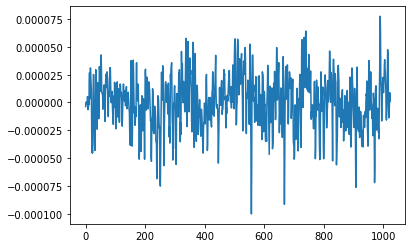

In [ ]:
plt.plot(np.array(inter_win[0][0]))

In [ ]:
241 * 6

1446 * 90


130140